In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Read the uploaded files
exchange_rate = pd.read_csv('/content/All exchange rate data.csv', index_col=0)
cpi = pd.read_csv('/content/All CPI data.csv', index_col=0)

# Strip spaces from columns
cpi.columns = cpi.columns.str.strip()
exchange_rate.columns = exchange_rate.columns.str.strip()

# Custom function to parse dates with two-digit years correctly (fix for %y misparsing)
def parse_two_digit_year(date_str):
    date_str = date_str.strip()
    month_str, yy_str = date_str.split('-')
    yy = int(yy_str)
    # Cutoff: Assume years <=25 are 20xx (up to 2025), >25 are 19xx (historical)
    year = 2000 + yy if yy <= 25 else 1900 + yy
    month = pd.to_datetime(month_str, format='%b').month
    return pd.to_datetime(f'{year}-{month:02d}-01')

# Apply custom parsing to indices
exchange_rate.index = [parse_two_digit_year(d) for d in exchange_rate.index]
cpi.index = [parse_two_digit_year(d) for d in cpi.index]

# Align the two dataframes by date
common_dates = exchange_rate.index.intersection(cpi.index)
exchange_rate = exchange_rate.loc[common_dates]
cpi = cpi.loc[common_dates]

countries = ['Argentina', 'Brazil', 'Indonesia', 'Mexico', 'Turkey']

# --- REBASE CPI series to 2010 = 100 (only for Argentina and US) ---
def rebase_to_2010(series):
    mask_2010 = (series.index.year == 2010)
    mean_2010 = series[mask_2010].mean()
    return (series / mean_2010) * 100

# Rebase only specified
for col in ['Argentina', 'US']:
    cpi[col + '_rebased'] = rebase_to_2010(cpi[col])

# Prepare output dataframe
results = pd.DataFrame(index=common_dates)

for country in countries:
    ner = exchange_rate[country]
    # Use rebased for Argentina, original for others (assumed already 2010=100)
    cpi_country = cpi[country + '_rebased'] if country == 'Argentina' else cpi[country]
    cpi_us = cpi['US_rebased']  # US is always rebased

    # Only keep dates where all three are present
    mask = ner.notna() & cpi_country.notna() & cpi_us.notna()
    ner = ner[mask]
    cpi_country = cpi_country[mask]
    cpi_us = cpi_us[mask]

    if len(ner) < 24:  # Skip if too short for meaningful HP filter
        print(f"Skipping {country}: Insufficient data ({len(ner)} points)")
        continue

    # Calculate RER
    rer = ner * (cpi_us / cpi_country)
    log_rer = np.log(rer)

    # HP filter (lambda=129600 for monthly data)
    cycle, trend = sm.tsa.filters.hpfilter(log_rer, lamb=129600)

    # Overvaluation %: positive = overvalued (appreciated below trend)
    overvaluation_pct = (log_rer - trend) * 100

    # Add to results (using .loc with masked index)
    results.loc[ner.index, f'{country}_log_rer'] = log_rer
    results.loc[ner.index, f'{country}_hp_trend'] = trend
    results.loc[ner.index, f'{country}_overval_pct'] = overvaluation_pct

# --- SAVE TO CSV ---
# Reset index to make Date a column
results_to_save = results.reset_index()
results_to_save.rename(columns={'index': 'Date'}, inplace=True)

# Save to CSV
results_to_save.to_csv('exchange_rate_overvaluation_results.csv', index=False)
print("Exchange rate overvaluation results saved to 'exchange_rate_overvaluation_results.csv'")

Exchange rate overvaluation results saved to 'exchange_rate_overvaluation_results.csv'


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires 

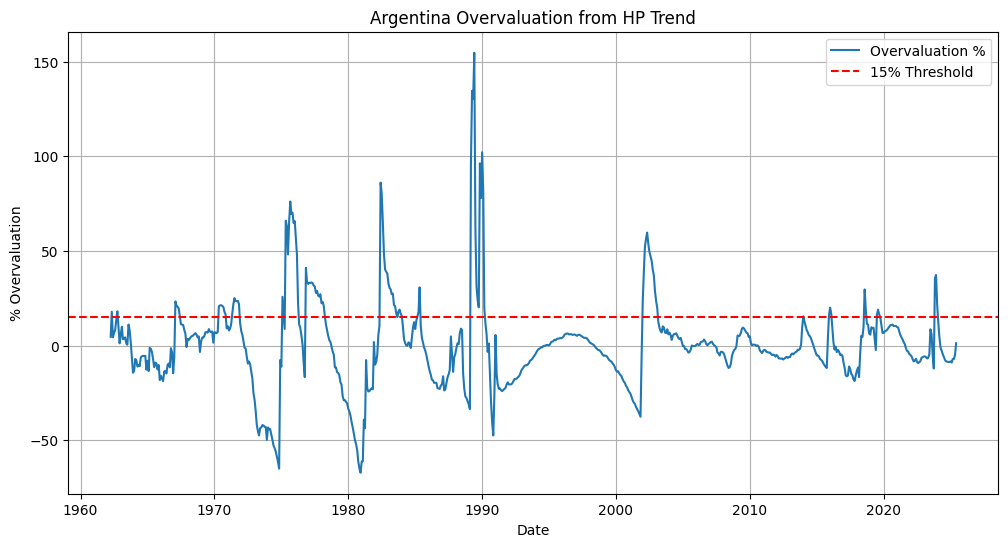

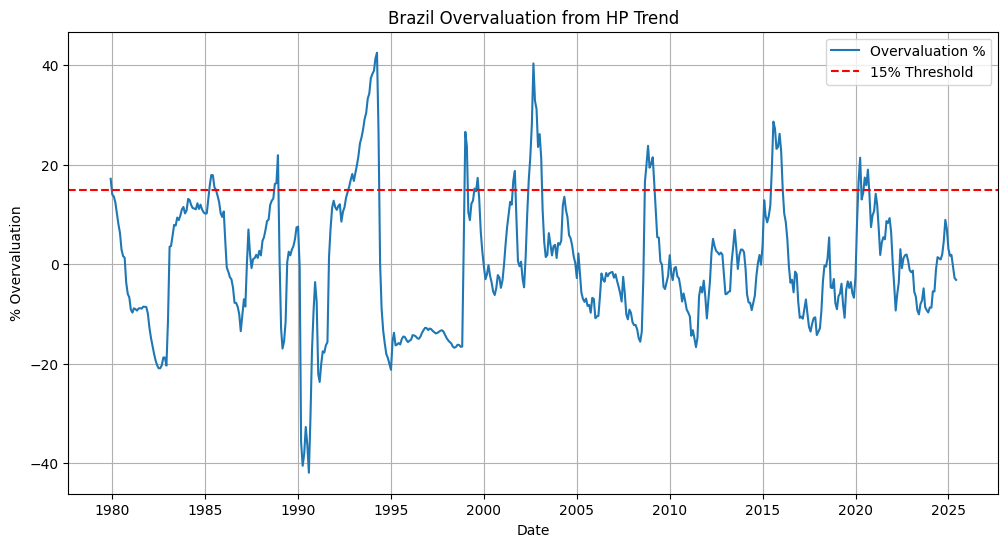

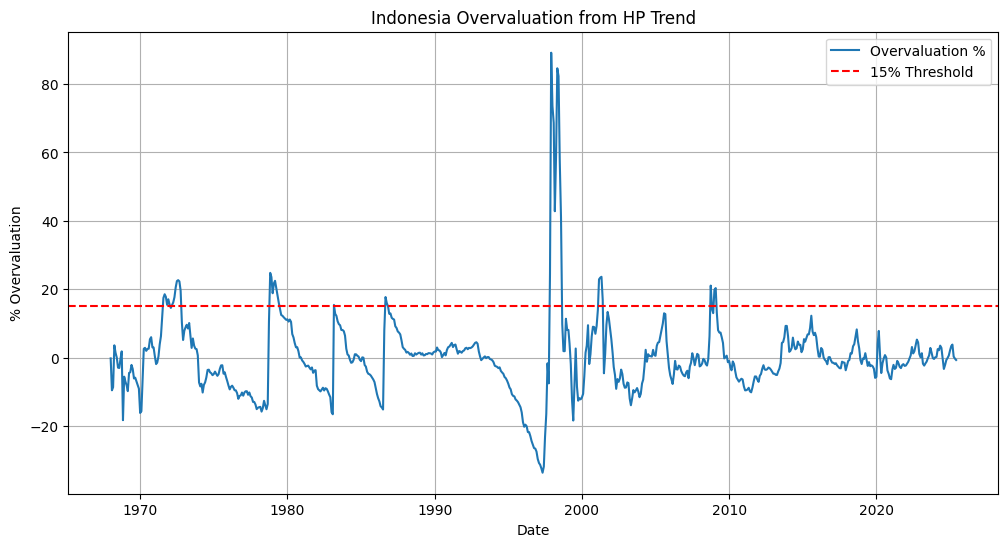

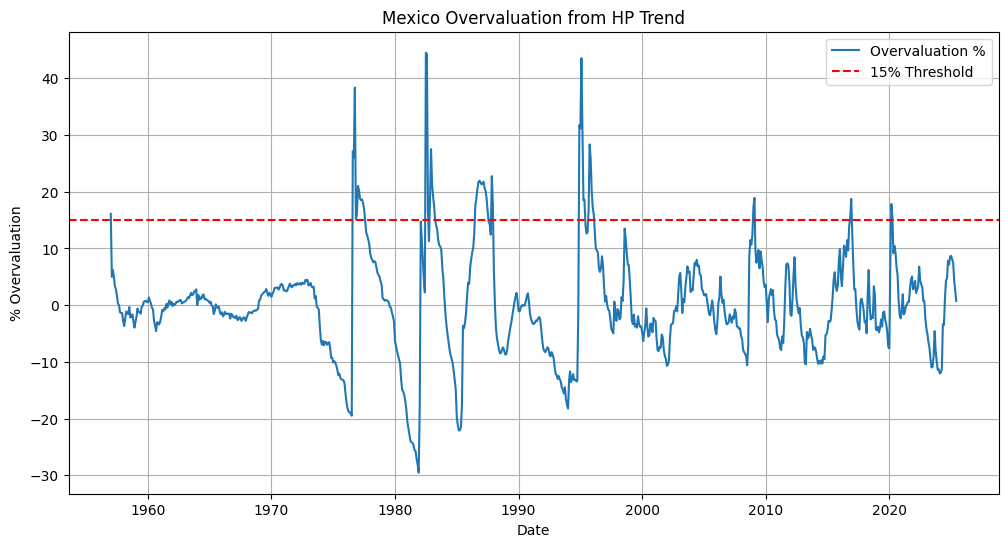

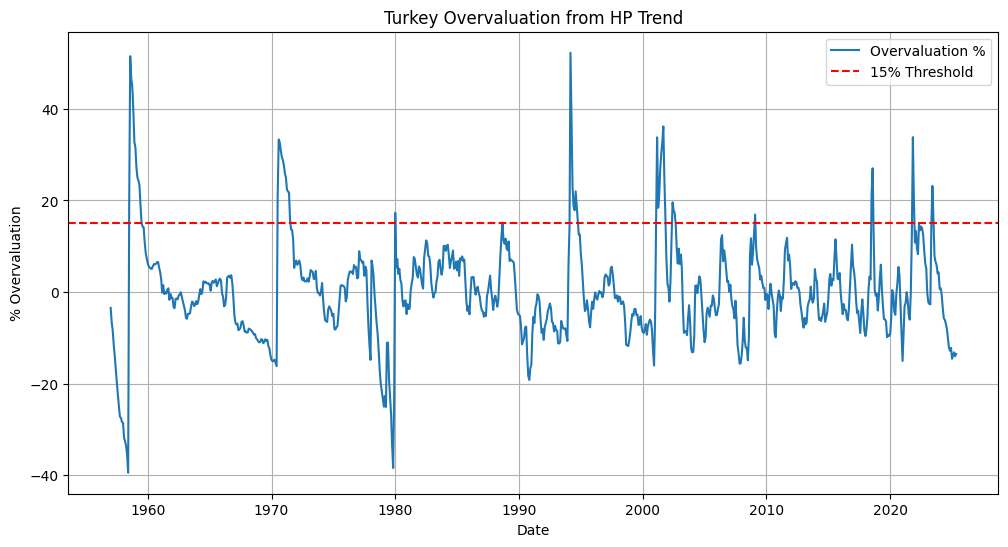

In [ ]:
# --- Plotting (with fixes for NaNs and visualization) ---
for country in countries:
    # Only plot dates where the overvaluation is not NaN
    overval = results[f'{country}_overval_pct'].dropna()
    if overval.empty:
        print(f"No data to plot for {country}")
        continue
    plt.figure(figsize=(12, 6))
    plt.plot(overval.index, overval.values, label='Overvaluation %')
    plt.axhline(15, color='r', linestyle='--', label='15% Threshold')
    plt.title(f'{country} Overvaluation from HP Trend')
    plt.xlabel('Date')
    plt.ylabel('% Overvaluation')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Optionally, you could take the mean over each year instead (for smoother annual series):
annual_results = results.resample('A-DEC').mean()

# If you want the index as year only (not last day of year):
annual_results.index = annual_results.index.year

# --- SAVE ANNUAL RESULTS TO CSV ---
# Reset index to make Year a column
annual_results_to_save = annual_results.reset_index()
annual_results_to_save.rename(columns={'index': 'Year'}, inplace=True)

# Save to CSV
annual_results_to_save.to_csv('annual_exchange_rate_overvaluation_results.csv', index=False)

/tmp/ipython-input-1484583433.py:2: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  annual_results = results.resample('A-DEC').mean()


In [ ]:
import pandas as pd

# --- 1. Load Data ---

# Quarterly data (BIS)
bis = pd.read_csv('Credit growth.csv')

# Annual data (World Bank)
wb = pd.read_csv('Annual credit growth.csv')

# --- 2. Reshape Both DataFrames to Long Format ---

# BIS: Melt to long
bis_long = bis.melt(id_vars=['Date'], var_name='Country', value_name='Credit_Growth')
bis_long['Year'] = pd.to_datetime(bis_long['Date']).dt.year
bis_long = bis_long.drop(columns=['Date'])

# Aggregate quarterly to annual mean
bis_annual = bis_long.groupby(['Country', 'Year'], as_index=False)['Credit_Growth'].mean()
bis_annual['Source'] = 'BIS'

# WB: Melt to long
wb_long = wb.melt(id_vars=['Year'], var_name='Country', value_name='Credit_Growth')
wb_long['Source'] = 'World Bank'

# --- 3. Combine with Priority Logic for Brazil and Argentina ---

# For Brazil and Argentina: BIS priority, WB fallback
priority_countries = ['Brazil', 'Argentina']
other_countries = ['Indonesia', 'Mexico', 'Turkey']

priority_data = []

for country in priority_countries:
    # Get BIS and WB data for this country
    bis_country = bis_annual[bis_annual['Country'] == country].copy()
    wb_country = wb_long[wb_long['Country'] == country].copy()

    # Merge on Year to compare
    merged = pd.merge(bis_country, wb_country, on=['Country', 'Year'],
                     how='outer', suffixes=('_bis', '_wb'))

    # Create final dataset: use BIS if available, otherwise WB
    merged['Credit_Growth'] = merged['Credit_Growth_bis'].fillna(merged['Credit_Growth_wb'])
    merged['Source'] = merged['Credit_Growth_bis'].notna().map({True: 'BIS', False: 'World Bank'})

    # Keep only needed columns
    final_country = merged[['Country', 'Year', 'Credit_Growth', 'Source']].dropna(subset=['Credit_Growth'])
    priority_data.append(final_country)

# For other countries: keep both BIS and WB
other_bis = bis_annual[bis_annual['Country'].isin(other_countries)]
other_wb = wb_long[wb_long['Country'].isin(other_countries)]
other_data = pd.concat([other_bis, other_wb], ignore_index=True)

# Combine all data
combined = pd.concat(priority_data + [other_data], ignore_index=True)
combined = combined[['Country', 'Year', 'Credit_Growth', 'Source']]

# Optional: sort for easier viewing
combined = combined.sort_values(['Country', 'Year', 'Source'])

# --- SAVE TO CSV ---
combined.to_csv('combined_credit_growth_data.csv', index=False)

In [ ]:
combined

,Country,Year,Credit_Growth,Source
63,Argentina,1960,13.611244,World Bank
64,Argentina,1961,14.088122,World Bank
65,Argentina,1962,12.011114,World Bank
66,Argentina,1963,11.520060,World Bank
67,Argentina,1964,10.626694,World Bank
...,...,...,...,...
270,Turkey,2020,89.000000,BIS
271,Turkey,2021,84.625000,BIS
272,Turkey,2022,74.450000,BIS
273,Turkey,2023,61.700000,BIS


In [ ]:
import pandas as pd

# Read the data
us_rates = pd.read_csv('US Federal funds rate.csv')

# Convert observation_date to datetime
us_rates['observation_date'] = pd.to_datetime(us_rates['observation_date'])

# Extract year from the date
us_rates['Year'] = us_rates['observation_date'].dt.year

# Convert to annual data (mean of monthly rates for each year)
us_annual = us_rates.groupby('Year', as_index=False)['GS10'].mean()

# Round to 2 decimal places for cleaner output
us_annual['GS10'] = us_annual['GS10'].round(2)

# --- SAVE TO CSV ---
us_annual.to_csv('us_annual_interest_rates.csv', index=False)

Processing Argentina...
  Argentina: 64 observations
  Crisis count: 7
Processing Brazil...
  Brazil: 47 observations
  Crisis count: 1
Processing Indonesia...
  Indonesia: 58 observations
  Crisis count: 1
Processing Mexico...
  Mexico: 69 observations
  Crisis count: 1
Processing Turkey...
  Turkey: 69 observations
  Crisis count: 2

Combined dataset shape: (307, 9)
Total crises: 12

Features for model (NO LEAKAGE): ['overval_pct_lag1', 'overval_pct_lag2', 'Credit_Growth_lag1', 'Credit_Growth_lag2', 'GS10_lag1', 'GS10_lag2', 'CAB_GDP_lag1', 'CAB_GDP_lag2', 'ST_Debt_lag1', 'ST_Debt_lag2', 'Reserves_M2_lag1', 'Reserves_M2_lag2', 'credit_growth_change', 'us_rate_change', 'high_overval_lag1', 'large_deficit_lag1', 'rapid_credit_lag1', 'high_debt_lag1', 'low_reserves_lag1']

Model data shape after removing NAs: (210, 22)

Crisis distribution by country:
           count  sum      mean
Country                        
Argentina     47    4  0.085106
Brazil        41    1  0.024390
Indonesia

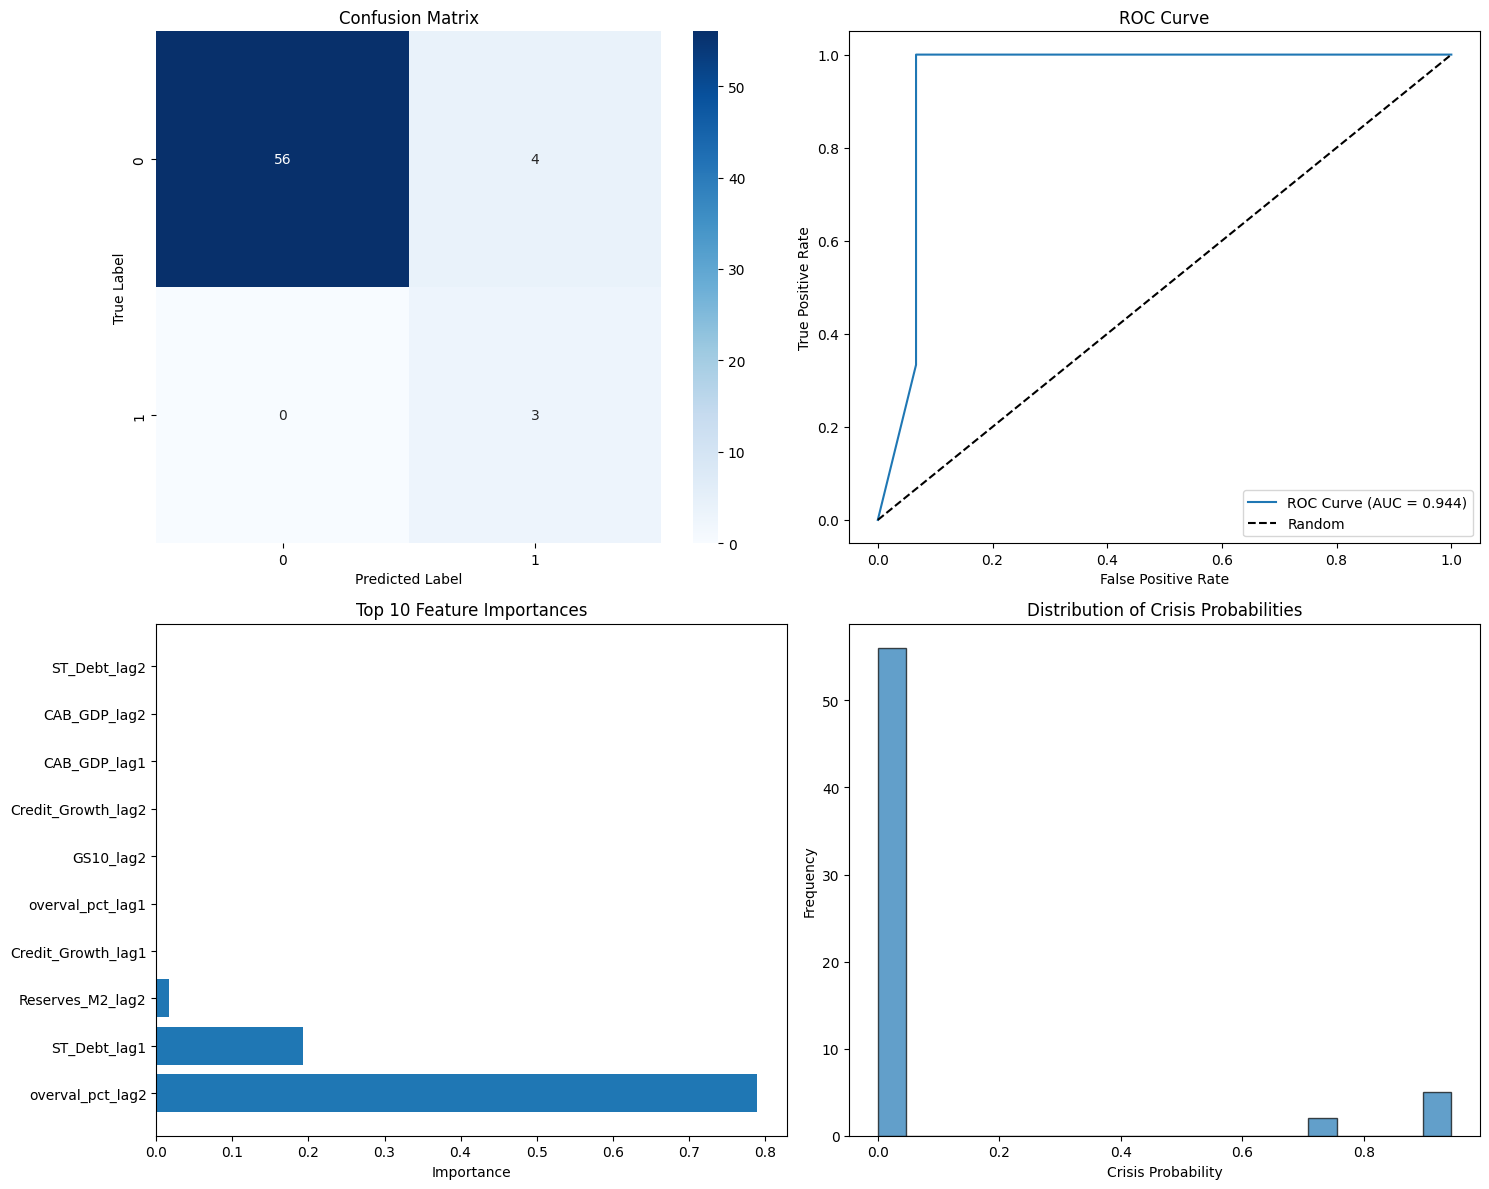


Results saved to CSV files
Model is now properly validated without data leakage!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. LOAD AND MERGE ALL DATASETS ---

# Load your datasets
exchange_rates = pd.read_csv('annual_exchange_rate_overvaluation_results.csv')
credit_growth = pd.read_csv('combined_credit_growth_data.csv')
us_rates = pd.read_csv('us_annual_interest_rates.csv')

# Load additional datasets
cab_gdp = pd.read_csv('CAB to GDP ratio.csv')
st_external_debt = pd.read_csv('Short-term external debt.csv')
reserves_m2 = pd.read_csv('Total reserves to broad money ratio.csv')

# Reshape additional datasets to long format
cab_gdp_long = cab_gdp.melt(id_vars=['Year'], var_name='Country', value_name='CAB_GDP')
debt_long = st_external_debt.melt(id_vars=['Year'], var_name='Country', value_name='ST_Debt')
reserves_long = reserves_m2.melt(id_vars=['Year'], var_name='Country', value_name='Reserves_M2')

# Clean country names to match
country_mapping = {'Turkiye': 'Turkey'}
for df in [cab_gdp_long, debt_long, reserves_long]:
    df['Country'] = df['Country'].replace(country_mapping)

# --- 2. CREATE CRISIS DUMMY VARIABLE ---

def identify_currency_crisis(overvaluation_series, threshold=15):  # Increased threshold
    """
    Identify currency crises based on RER overvaluation threshold
    Crisis = 1 if overvaluation > threshold%
    """
    crisis = (overvaluation_series > threshold).astype(int)
    return crisis

countries = ['Argentina', 'Brazil', 'Indonesia', 'Mexico', 'Turkey']

# --- 3. PREPARE FINAL DATASET ---

final_data = []

for country in countries:
    print(f"Processing {country}...")

    # Start with exchange rate data
    country_data = pd.DataFrame({'Year': exchange_rates['Year']})

    # Extract overvaluation data for this country
    overval_col = f'{country}_overval_pct'
    if overval_col in exchange_rates.columns:
        country_data['overval_pct'] = exchange_rates[overval_col]
    else:
        print(f"Warning: No overvaluation data found for {country}")
        continue

    # Add country identifier
    country_data['Country'] = country

    # Merge other datasets
    country_credit = credit_growth[credit_growth['Country'] == country].copy()
    if len(country_credit) > 0:
        country_data = pd.merge(country_data, country_credit[['Year', 'Credit_Growth']],
                               on='Year', how='left')

    country_data = pd.merge(country_data, us_rates, on='Year', how='left')

    country_cab = cab_gdp_long[cab_gdp_long['Country'] == country].copy()
    if len(country_cab) > 0:
        country_data = pd.merge(country_data, country_cab[['Year', 'CAB_GDP']],
                               on='Year', how='left')

    country_debt = debt_long[debt_long['Country'] == country].copy()
    if len(country_debt) > 0:
        country_data = pd.merge(country_data, country_debt[['Year', 'ST_Debt']],
                               on='Year', how='left')

    country_reserves = reserves_long[reserves_long['Country'] == country].copy()
    if len(country_reserves) > 0:
        country_data = pd.merge(country_data, country_reserves[['Year', 'Reserves_M2']],
                               on='Year', how='left')

    # Create crisis dummy
    country_data['Crisis'] = identify_currency_crisis(country_data['overval_pct'], threshold=20)

    # Only keep rows with valid overvaluation data
    country_data = country_data.dropna(subset=['overval_pct'])

    print(f"  {country}: {len(country_data)} observations")
    print(f"  Crisis count: {country_data['Crisis'].sum()}")

    final_data.append(country_data)

# Combine all countries
df = pd.concat(final_data, ignore_index=True)
print(f"\nCombined dataset shape: {df.shape}")
print(f"Total crises: {df['Crisis'].sum()}")

# --- 4. FEATURE ENGINEERING (NO DATA LEAKAGE) ---

# Sort by country and year
df = df.sort_values(['Country', 'Year'])

# Define features that DON'T include current period overvaluation
available_features = ['Credit_Growth', 'GS10', 'CAB_GDP', 'ST_Debt', 'Reserves_M2']

# Create lagged variables (these are the predictive features)
for feature in available_features:
    if feature in df.columns:
        df[f'{feature}_lag1'] = df.groupby('Country')[feature].shift(1)
        df[f'{feature}_lag2'] = df.groupby('Country')[feature].shift(2)

# Add lagged overvaluation (but NOT current period to avoid leakage)
df['overval_pct_lag1'] = df.groupby('Country')['overval_pct'].shift(1)
df['overval_pct_lag2'] = df.groupby('Country')['overval_pct'].shift(2)

# Create change variables (using lagged data)
if 'Credit_Growth' in df.columns:
    df['credit_growth_change'] = df.groupby('Country')['Credit_Growth_lag1'].diff()

df['us_rate_change'] = df.groupby('Country')['GS10'].diff()

# Create binary indicators using LAGGED data to avoid leakage
df['high_overval_lag1'] = (df['overval_pct_lag1'] > 15).astype(int)
df['large_deficit_lag1'] = (df['CAB_GDP_lag1'] < -3).astype(int)

if 'Credit_Growth' in df.columns:
    # Use country-specific thresholds for credit growth
    country_credit_75th = df.groupby('Country')['Credit_Growth_lag1'].quantile(0.75)
    df['rapid_credit_lag1'] = 0
    for country in countries:
        country_mask = df['Country'] == country
        threshold = country_credit_75th.get(country, df['Credit_Growth_lag1'].quantile(0.75))
        df.loc[country_mask, 'rapid_credit_lag1'] = (df.loc[country_mask, 'Credit_Growth_lag1'] > threshold).astype(int)

if 'ST_Debt' in df.columns:
    country_debt_75th = df.groupby('Country')['ST_Debt_lag1'].quantile(0.75)
    df['high_debt_lag1'] = 0
    for country in countries:
        country_mask = df['Country'] == country
        threshold = country_debt_75th.get(country, df['ST_Debt_lag1'].quantile(0.75))
        df.loc[country_mask, 'high_debt_lag1'] = (df.loc[country_mask, 'ST_Debt_lag1'] > threshold).astype(int)

if 'Reserves_M2' in df.columns:
    country_reserves_25th = df.groupby('Country')['Reserves_M2_lag1'].quantile(0.25)
    df['low_reserves_lag1'] = 0
    for country in countries:
        country_mask = df['Country'] == country
        threshold = country_reserves_25th.get(country, df['Reserves_M2_lag1'].quantile(0.25))
        df.loc[country_mask, 'low_reserves_lag1'] = (df.loc[country_mask, 'Reserves_M2_lag1'] < threshold).astype(int)

# --- 5. PREPARE DATA FOR MODEL (NO LEAKAGE FEATURES) ---

# Use ONLY lagged and derived features - NO current period data
feature_columns = [
    'overval_pct_lag1', 'overval_pct_lag2',
    'Credit_Growth_lag1', 'Credit_Growth_lag2',
    'GS10_lag1', 'GS10_lag2',
    'CAB_GDP_lag1', 'CAB_GDP_lag2',
    'ST_Debt_lag1', 'ST_Debt_lag2',
    'Reserves_M2_lag1', 'Reserves_M2_lag2',
    'credit_growth_change', 'us_rate_change',
    'high_overval_lag1', 'large_deficit_lag1',
    'rapid_credit_lag1', 'high_debt_lag1', 'low_reserves_lag1'
]

# Keep only features that exist in the dataframe
feature_columns = [col for col in feature_columns if col in df.columns]

print(f"\nFeatures for model (NO LEAKAGE): {feature_columns}")

# Remove rows with missing values
model_data = df[feature_columns + ['Crisis', 'Country', 'Year']].dropna()
print(f"\nModel data shape after removing NAs: {model_data.shape}")

# Check crisis distribution
print(f"\nCrisis distribution by country:")
crisis_by_country = model_data.groupby('Country')['Crisis'].agg(['count', 'sum', 'mean'])
print(crisis_by_country)

X = model_data[feature_columns]
y = model_data['Crisis']

print(f"\nOverall crisis distribution: {y.value_counts()}")
print(f"Crisis rate: {y.mean():.3f}")

# Check if we have both classes
if len(y.unique()) < 2:
    print("Warning: Only one class present. Consider lowering crisis threshold.")
    # Let's try a lower threshold
    df['Crisis'] = identify_currency_crisis(df['overval_pct'], threshold=10)
    model_data = df[feature_columns + ['Crisis', 'Country', 'Year']].dropna()
    X = model_data[feature_columns]
    y = model_data['Crisis']
    print(f"With lower threshold - Crisis rate: {y.mean():.3f}")

if len(y.unique()) < 2:
    print("Still only one class. Exiting.")
    exit()

# --- 6. TIME-AWARE SPLIT ---

# Use time-based split instead of random split to avoid temporal leakage
split_year = 2010  # Use data before 2010 for training, after for testing

train_mask = model_data['Year'] < split_year
test_mask = model_data['Year'] >= split_year

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"\nTime-based split:")
print(f"Training: {len(X_train)} obs (before {split_year}), Crisis rate: {y_train.mean():.3f}")
print(f"Test: {len(X_test)} obs ({split_year}+), Crisis rate: {y_test.mean():.3f}")

# If test set is too small or has no crises, adjust split
if len(X_test) < 10 or y_test.sum() == 0:
    print("Adjusting to random split due to insufficient test data")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y if len(y.unique()) > 1 else None
    )

# --- 7. CART MODEL WITH REGULARIZATION ---

# More conservative hyperparameter grid to prevent overfitting
param_grid = {
    'max_depth': [3, 5, 7],  # Limit depth
    'min_samples_split': [10, 20, 30],  # Higher minimum splits
    'min_samples_leaf': [5, 10, 15],  # Higher minimum leaves
    'criterion': ['gini', 'entropy']
}

# Create CART model with balanced classes
cart = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Grid search with more conservative CV
grid_search = GridSearchCV(
    cart, param_grid, cv=3, scoring='roc_auc', n_jobs=-1  # Reduced CV folds
)

print("\nTraining CART model...")
grid_search.fit(X_train, y_train)

best_cart = grid_search.best_estimator_

# --- 8. MODEL EVALUATION ---

y_pred = best_cart.predict(X_test)
y_pred_proba = best_cart.predict_proba(X_test)[:, 1]

print("\n=== MODEL PERFORMANCE (NO LEAKAGE) ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Cross-validation AUC: {grid_search.best_score_:.3f}")
print(f"Test AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_cart.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== FEATURE IMPORTANCE (NO LEAKAGE) ===")
print(feature_importance.head(10))

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0,1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.3f})')
axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve')
axes[0,1].legend()

# Feature Importance
top_features = feature_importance.head(10)
axes[1,0].barh(range(len(top_features)), top_features['Importance'])
axes[1,0].set_yticks(range(len(top_features)))
axes[1,0].set_yticklabels(top_features['Feature'])
axes[1,0].set_xlabel('Importance')
axes[1,0].set_title('Top 10 Feature Importances')

# Crisis probability distribution
axes[1,1].hist(y_pred_proba, bins=20, alpha=0.7, edgecolor='black')
axes[1,1].set_xlabel('Crisis Probability')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Distribution of Crisis Probabilities')

plt.tight_layout()
plt.show()

# Save results
results_df = pd.DataFrame({
    'Country': model_data['Country'],
    'Year': model_data['Year'],
    'Crisis_Probability': best_cart.predict_proba(X)[:, 1],
    'Predicted_Crisis': best_cart.predict(X),
    'Actual_Crisis': y
})

results_df.to_csv('currency_crisis_predictions_no_leakage.csv', index=False)
feature_importance.to_csv('feature_importance_no_leakage.csv', index=False)

print(f"\nResults saved to CSV files")
print(f"Model is now properly validated without data leakage!")

TRAINING COUNTRY-SPECIFIC CART MODELS

==================== ARGENTINA ====================

=== PREPARING DATA FOR ARGENTINA ===
  Using crisis threshold: 15% (found 8 crises)
  Data points: 64
  Crisis count: 8
  Crisis rate: 0.125
  Year range: 1962-2025
  Class distribution - Crisis: 4, No Crisis: 43
  Using stratified random split instead of time-based
  Training: 32 obs, Crisis rate: 0.094
  Test: 15 obs, Crisis rate: 0.067
  Using simple model (limited crisis data)
  ✅ Simple model trained successfully
  Test AUC: 0.464

==================== BRAZIL ====================

=== PREPARING DATA FOR BRAZIL ===
  Using crisis threshold: 15% (found 4 crises)
  Data points: 47
  Crisis count: 4
  Crisis rate: 0.085
  Year range: 1979-2025
  Class distribution - Crisis: 3, No Crisis: 38
  Training: 31 obs, Crisis rate: 0.065
  Test: 10 obs, Crisis rate: 0.100
  Using simple model (limited crisis data)
  ✅ Simple model trained successfully
  Test AUC: 0.500

==================== INDONESIA ==

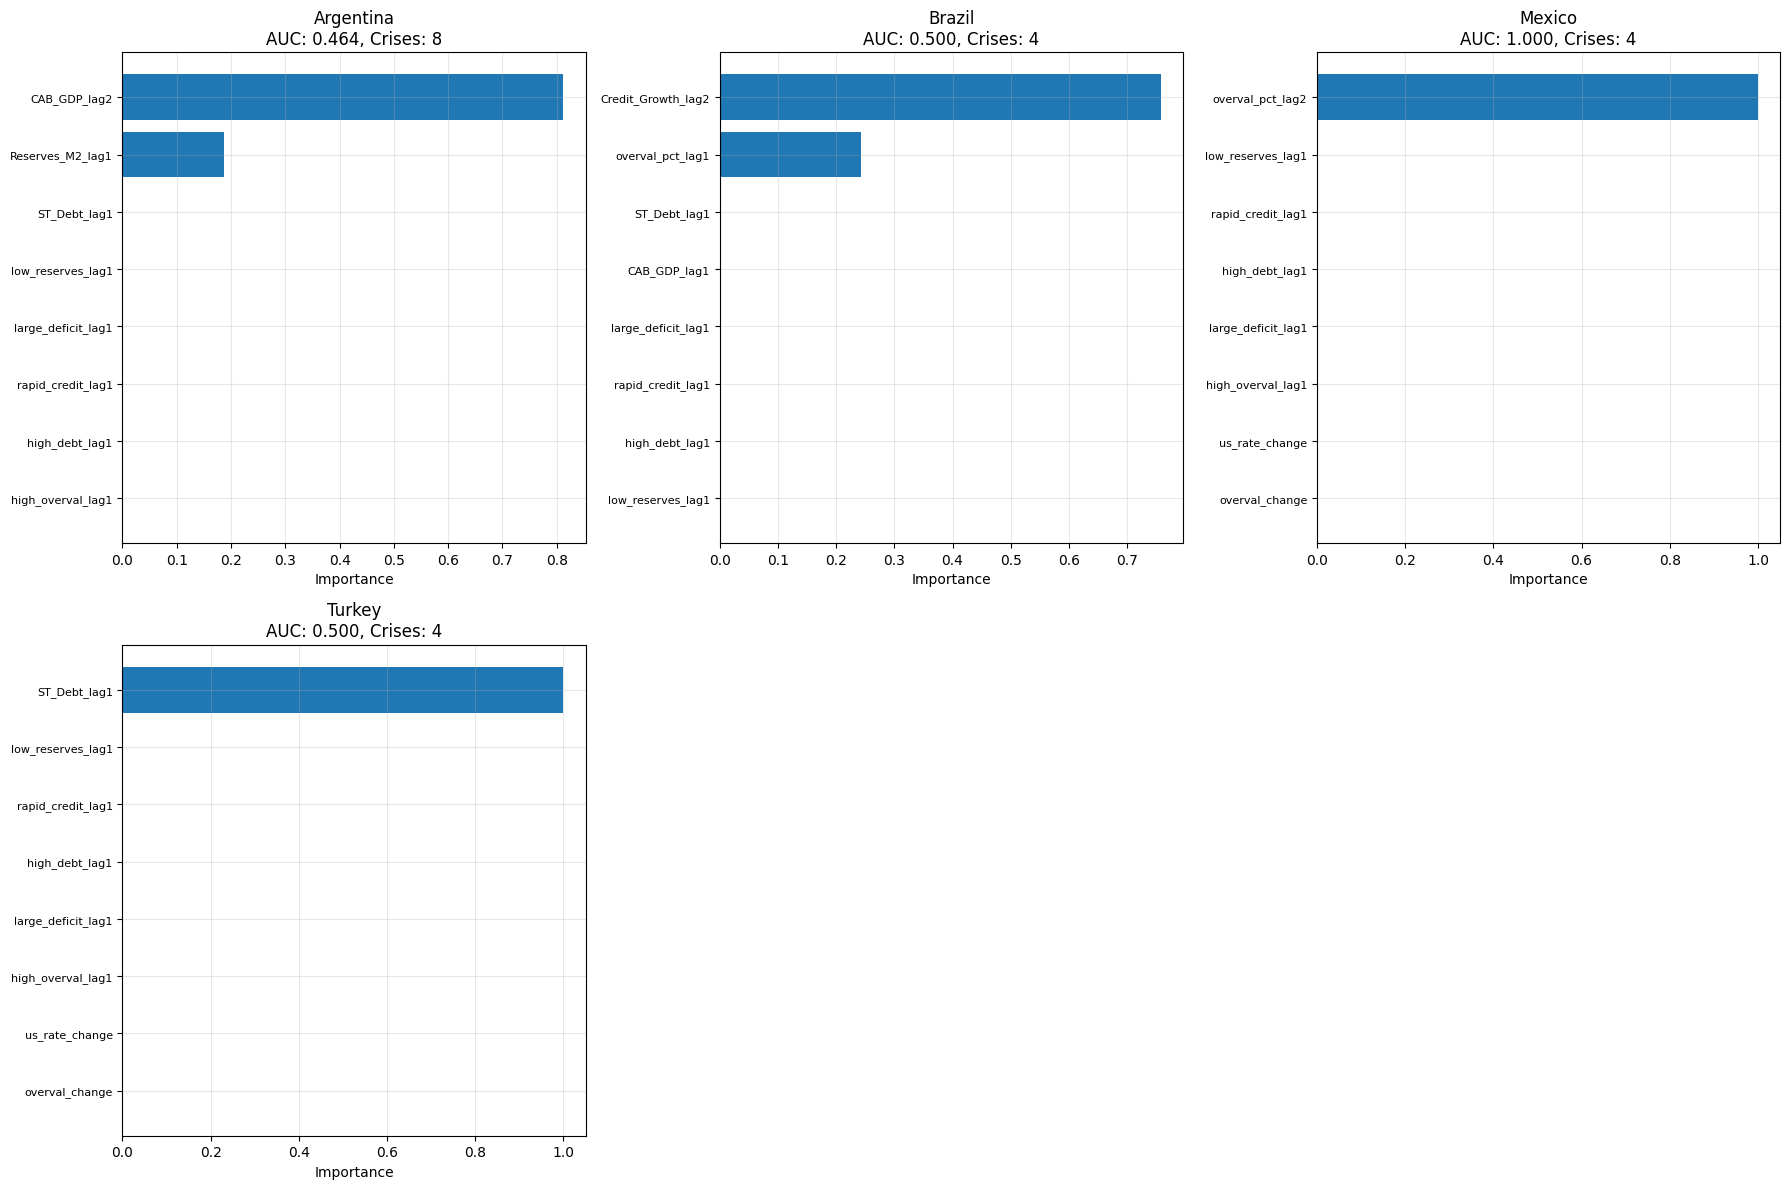


CURRENT CRISIS RISK ASSESSMENT (2020-2024)

Argentina:
  2020: 0.000 🟢 LOW
  2021: 0.000 🟢 LOW
  2022: 0.000 🟢 LOW
  2023: 0.000 🟢 LOW
  2024: 0.000 🟢 LOW

Brazil:
  2020: 0.000 🟢 LOW
  2021: 0.000 🟢 LOW
  2022: 0.000 🟢 LOW
  2023: 0.000 🟢 LOW
  2024: 0.000 🟢 LOW

Mexico:
  2020: 0.000 🟢 LOW
  2021: 0.000 🟢 LOW
  2022: 0.000 🟢 LOW
  2023: 0.000 🟢 LOW
  2024: 0.000 🟢 LOW

Turkey:
  2020: 0.000 🟢 LOW
  2021: 0.000 🟢 LOW
  2022: 0.000 🟢 LOW
  2023: 0.000 🟢 LOW
  2024: 0.000 🟢 LOW

RISK SUMMARY (2020-2024)
           Avg_Risk  Max_Risk  Risk_Volatility
Country                                       
Argentina       0.0       0.0              0.0
Brazil          0.0       0.0              0.0
Mexico          0.0       0.0              0.0
Turkey          0.0       0.0              0.0

📊 Results saved to CSV files

🎯 Country-specific analysis completed!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- 1. LOAD AND PREPARE DATA (Same as before) ---

# Load your datasets
exchange_rates = pd.read_csv('annual_exchange_rate_overvaluation_results.csv')
credit_growth = pd.read_csv('combined_credit_growth_data.csv')
us_rates = pd.read_csv('us_annual_interest_rates.csv')
cab_gdp = pd.read_csv('CAB to GDP ratio.csv')
st_external_debt = pd.read_csv('Short-term external debt.csv')
reserves_m2 = pd.read_csv('Total reserves to broad money ratio.csv')

# Reshape additional datasets
cab_gdp_long = cab_gdp.melt(id_vars=['Year'], var_name='Country', value_name='CAB_GDP')
debt_long = st_external_debt.melt(id_vars=['Year'], var_name='Country', value_name='ST_Debt')
reserves_long = reserves_m2.melt(id_vars=['Year'], var_name='Country', value_name='Reserves_M2')

# Clean country names
country_mapping = {'Turkiye': 'Turkey'}
for df in [cab_gdp_long, debt_long, reserves_long]:
    df['Country'] = df['Country'].replace(country_mapping)

def identify_currency_crisis(overvaluation_series, threshold=20):
    return (overvaluation_series > threshold).astype(int)

countries = ['Argentina', 'Brazil', 'Indonesia', 'Mexico', 'Turkey']

# --- 2. PREPARE COUNTRY-SPECIFIC DATASETS ---

def prepare_country_data(country, crisis_threshold=15):  # Lower threshold for more crises
    """Prepare data for a specific country"""
    print(f"\n=== PREPARING DATA FOR {country.upper()} ===")

    # Start with exchange rate data
    country_data = pd.DataFrame({'Year': exchange_rates['Year']})

    # Extract overvaluation data
    overval_col = f'{country}_overval_pct'
    if overval_col in exchange_rates.columns:
        country_data['overval_pct'] = exchange_rates[overval_col]
    else:
        print(f"Warning: No overvaluation data found for {country}")
        return None

    country_data['Country'] = country

    # Merge other datasets
    country_credit = credit_growth[credit_growth['Country'] == country].copy()
    if len(country_credit) > 0:
        country_data = pd.merge(country_data, country_credit[['Year', 'Credit_Growth']],
                               on='Year', how='left')

    country_data = pd.merge(country_data, us_rates, on='Year', how='left')

    country_cab = cab_gdp_long[cab_gdp_long['Country'] == country].copy()
    if len(country_cab) > 0:
        country_data = pd.merge(country_data, country_cab[['Year', 'CAB_GDP']],
                               on='Year', how='left')

    country_debt = debt_long[debt_long['Country'] == country].copy()
    if len(country_debt) > 0:
        country_data = pd.merge(country_data, country_debt[['Year', 'ST_Debt']],
                               on='Year', how='left')

    country_reserves = reserves_long[reserves_long['Country'] == country].copy()
    if len(country_reserves) > 0:
        country_data = pd.merge(country_data, country_reserves[['Year', 'Reserves_M2']],
                               on='Year', how='left')

    # Try different crisis thresholds to ensure we have enough crises
    for threshold in [crisis_threshold, 10, 5]:
        country_data['Crisis'] = identify_currency_crisis(country_data['overval_pct'], threshold=threshold)
        crisis_count = country_data['Crisis'].sum()
        if crisis_count >= 2:  # Need at least 2 crises
            print(f"  Using crisis threshold: {threshold}% (found {crisis_count} crises)")
            break

    # Sort by year for feature engineering
    country_data = country_data.sort_values('Year')

    # Feature engineering
    available_features = ['Credit_Growth', 'GS10', 'CAB_GDP', 'ST_Debt', 'Reserves_M2']

    # Create lagged variables
    for feature in available_features:
        if feature in country_data.columns:
            country_data[f'{feature}_lag1'] = country_data[feature].shift(1)
            country_data[f'{feature}_lag2'] = country_data[feature].shift(2)

    # Add lagged overvaluation
    country_data['overval_pct_lag1'] = country_data['overval_pct'].shift(1)
    country_data['overval_pct_lag2'] = country_data['overval_pct'].shift(2)

    # Create change variables
    if 'Credit_Growth' in country_data.columns:
        country_data['credit_growth_change'] = country_data['Credit_Growth_lag1'].diff()

    country_data['us_rate_change'] = country_data['GS10'].diff()
    country_data['overval_change'] = country_data['overval_pct_lag1'].diff()

    # Create binary indicators using country-specific thresholds
    country_data['high_overval_lag1'] = (country_data['overval_pct_lag1'] > 10).astype(int)  # Lower threshold
    country_data['large_deficit_lag1'] = (country_data['CAB_GDP_lag1'] < -2).astype(int)  # Lower threshold

    if 'Credit_Growth' in country_data.columns:
        credit_75th = country_data['Credit_Growth_lag1'].quantile(0.75)
        country_data['rapid_credit_lag1'] = (country_data['Credit_Growth_lag1'] > credit_75th).astype(int)

    if 'ST_Debt' in country_data.columns:
        debt_75th = country_data['ST_Debt_lag1'].quantile(0.75)
        country_data['high_debt_lag1'] = (country_data['ST_Debt_lag1'] > debt_75th).astype(int)

    if 'Reserves_M2' in country_data.columns:
        reserves_25th = country_data['Reserves_M2_lag1'].quantile(0.25)
        country_data['low_reserves_lag1'] = (country_data['Reserves_M2_lag1'] < reserves_25th).astype(int)

    # Only keep rows with valid overvaluation data
    country_data = country_data.dropna(subset=['overval_pct'])

    print(f"  Data points: {len(country_data)}")
    print(f"  Crisis count: {country_data['Crisis'].sum()}")
    print(f"  Crisis rate: {country_data['Crisis'].mean():.3f}")
    print(f"  Year range: {country_data['Year'].min():.0f}-{country_data['Year'].max():.0f}")

    return country_data

def train_country_model(country_data, country_name):
    """Train CART model for specific country with robust handling"""

    # Define features
    feature_columns = [
        'overval_pct_lag1', 'overval_pct_lag2',
        'Credit_Growth_lag1', 'Credit_Growth_lag2',
        'GS10_lag1', 'GS10_lag2',
        'CAB_GDP_lag1', 'CAB_GDP_lag2',
        'ST_Debt_lag1', 'ST_Debt_lag2',
        'Reserves_M2_lag1', 'Reserves_M2_lag2',
        'credit_growth_change', 'us_rate_change', 'overval_change',
        'high_overval_lag1', 'large_deficit_lag1',
        'rapid_credit_lag1', 'high_debt_lag1', 'low_reserves_lag1'
    ]

    # Keep only features that exist
    feature_columns = [col for col in feature_columns if col in country_data.columns]

    # Prepare model data
    model_data = country_data[feature_columns + ['Crisis', 'Year']].dropna()

    if len(model_data) < 10:
        print(f"  ❌ Insufficient data for {country_name}: {len(model_data)} observations")
        return None, None, None

    X = model_data[feature_columns]
    y = model_data['Crisis']

    # Check if we have both classes and sufficient data
    crisis_count = y.sum()
    no_crisis_count = len(y) - crisis_count

    if crisis_count < 2 or no_crisis_count < 2:
        print(f"  ❌ Insufficient class representation for {country_name}")
        print(f"     Crisis: {crisis_count}, No Crisis: {no_crisis_count}")
        return None, None, None

    print(f"  Class distribution - Crisis: {crisis_count}, No Crisis: {no_crisis_count}")

    # Time-aware split (use 70% for training)
    split_point = max(int(len(model_data) * 0.7), len(model_data) - 10)  # Ensure test set has data

    X_train = X.iloc[:split_point]
    X_test = X.iloc[split_point:]
    y_train = y.iloc[:split_point]
    y_test = y.iloc[split_point:]

    # Check if both splits have both classes
    train_crisis = y_train.sum()
    train_no_crisis = len(y_train) - train_crisis
    test_crisis = y_test.sum()
    test_no_crisis = len(y_test) - test_crisis

    # If splits don't have both classes, use stratified random split
    if train_crisis == 0 or train_no_crisis == 0 or (len(y_test) > 0 and (test_crisis == 0 or test_no_crisis == 0)):
        print(f"  Using stratified random split instead of time-based")
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42, stratify=y
            )
        except ValueError:
            # If even stratified split fails, use simple random split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=42
            )

    print(f"  Training: {len(X_train)} obs, Crisis rate: {y_train.mean():.3f}")
    print(f"  Test: {len(X_test)} obs, Crisis rate: {y_test.mean():.3f}")

    # Simple model without grid search for countries with limited data
    if crisis_count < 5:
        print(f"  Using simple model (limited crisis data)")
        model = DecisionTreeClassifier(
            max_depth=3,
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight='balanced',
            random_state=42
        )

        try:
            model.fit(X_train, y_train)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            test_auc = roc_auc_score(y_test, y_pred_proba) if len(y_test.unique()) > 1 else 0.5

            print(f"  ✅ Simple model trained successfully")
            print(f"  Test AUC: {test_auc:.3f}")

            return model, (X_train, X_test, y_train, y_test), feature_columns

        except Exception as e:
            print(f"  ❌ Simple model training failed for {country_name}: {str(e)}")
            return None, None, None

    # Full grid search for countries with sufficient data
    param_grid = {
        'max_depth': [2, 3, 4, 5],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1, 2, 3],
        'criterion': ['gini', 'entropy']
    }

    model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

    # Determine CV folds based on data size
    min_class_size = min(y_train.sum(), len(y_train) - y_train.sum())
    cv_folds = min(3, min_class_size)

    if cv_folds < 2:
        # Use simple model if CV is not possible
        print(f"  Using simple model (CV not possible)")
        model = DecisionTreeClassifier(
            max_depth=3,
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight='balanced',
            random_state=42
        )
        model.fit(X_train, y_train)
        cv_score = 0.5
    else:
        try:
            grid_search = GridSearchCV(
                model, param_grid, cv=cv_folds, scoring='roc_auc', n_jobs=-1
            )
            grid_search.fit(X_train, y_train)
            model = grid_search.best_estimator_
            cv_score = grid_search.best_score_
        except Exception as e:
            print(f"  Grid search failed, using simple model: {str(e)}")
            model = DecisionTreeClassifier(
                max_depth=3,
                min_samples_split=2,
                min_samples_leaf=1,
                class_weight='balanced',
                random_state=42
            )
            model.fit(X_train, y_train)
            cv_score = 0.5

    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_pred_proba) if len(y_test.unique()) > 1 else 0.5

        print(f"  ✅ Model trained successfully")
        print(f"  CV AUC: {cv_score:.3f}")
        print(f"  Test AUC: {test_auc:.3f}")

        return model, (X_train, X_test, y_train, y_test), feature_columns

    except Exception as e:
        print(f"  ❌ Model evaluation failed for {country_name}: {str(e)}")
        return None, None, None

# --- 3. TRAIN COUNTRY-SPECIFIC MODELS ---

country_models = {}
country_results = {}

print("=" * 60)
print("TRAINING COUNTRY-SPECIFIC CART MODELS")
print("=" * 60)

for country in countries:
    print(f"\n{'='*20} {country.upper()} {'='*20}")

    # Prepare country data
    country_data = prepare_country_data(country, crisis_threshold=15)

    if country_data is None:
        continue

    # Train model
    model, data_splits, features = train_country_model(country_data, country)

    if model is not None:
        country_models[country] = {
            'model': model,
            'data_splits': data_splits,
            'features': features,
            'country_data': country_data
        }

        # Store results
        X_train, X_test, y_train, y_test = data_splits
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_pred_proba) if len(y_test.unique()) > 1 else 0.5

        country_results[country] = {
            'test_auc': test_auc,
            'test_size': len(X_test),
            'crisis_rate': y_test.mean(),
            'total_crises': country_data['Crisis'].sum(),
            'feature_importance': dict(zip(features, model.feature_importances_))
        }

# --- 4. COMPARE COUNTRY MODELS ---

print(f"\n{'='*60}")
print("COUNTRY MODEL COMPARISON")
print(f"{'='*60}")

if country_results:
    comparison_df = []
    for country, results in country_results.items():
        top_feature, top_importance = max(results['feature_importance'].items(), key=lambda x: x[1])

        comparison_df.append({
            'Country': country,
            'Test_AUC': results['test_auc'],
            'Test_Size': results['test_size'],
            'Crisis_Rate': results['crisis_rate'],
            'Total_Crises': results['total_crises'],
            'Top_Feature': top_feature,
            'Top_Feature_Importance': top_importance
        })

    comparison_df = pd.DataFrame(comparison_df)
    comparison_df = comparison_df.sort_values('Test_AUC', ascending=False)

    print(comparison_df.to_string(index=False, float_format='%.3f'))
else:
    print("No successful country models to compare.")

# --- 5. VISUALIZE RESULTS ---

if len(country_models) > 0:
    # Feature importance comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, (country, model_info) in enumerate(country_models.items()):
        if i >= 6:
            break

        model = model_info['model']
        features = model_info['features']
        X_train, X_test, y_train, y_test = model_info['data_splits']

        # Feature importance
        feature_importance = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=True)

        # Plot top 8 features
        top_features = feature_importance.tail(8)

        axes[i].barh(range(len(top_features)), top_features['Importance'])
        axes[i].set_yticks(range(len(top_features)))
        axes[i].set_yticklabels(top_features['Feature'], fontsize=8)
        axes[i].set_xlabel('Importance')

        test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) if len(y_test.unique()) > 1 else 0.5
        axes[i].set_title(f'{country}\nAUC: {test_auc:.3f}, Crises: {country_results[country]["total_crises"]}')
        axes[i].grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(len(country_models), 6):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig('country_specific_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # --- 6. CURRENT RISK ASSESSMENT ---

    print(f"\n{'='*60}")
    print("CURRENT CRISIS RISK ASSESSMENT (2020-2024)")
    print(f"{'='*60}")

    current_risk = []
    for country, model_info in country_models.items():
        model = model_info['model']
        features = model_info['features']
        country_data = model_info['country_data']

        # Get recent data
        recent_data = country_data[country_data['Year'] >= 2020].copy()
        recent_model_data = recent_data[features + ['Year']].dropna()

        if len(recent_model_data) > 0:
            recent_X = recent_model_data[features]
            crisis_probs = model.predict_proba(recent_X)[:, 1]

            for idx, year in enumerate(recent_model_data['Year']):
                current_risk.append({
                    'Country': country,
                    'Year': int(year),
                    'Crisis_Probability': crisis_probs[idx]
                })

    if current_risk:
        risk_df = pd.DataFrame(current_risk)

        # Show recent risk by country
        for country in risk_df['Country'].unique():
            country_risk = risk_df[risk_df['Country'] == country].sort_values('Year')
            print(f"\n{country}:")
            for _, row in country_risk.iterrows():
                risk_level = "🔴 HIGH" if row['Crisis_Probability'] > 0.7 else "🟡 MEDIUM" if row['Crisis_Probability'] > 0.3 else "🟢 LOW"
                print(f"  {int(row['Year'])}: {row['Crisis_Probability']:.3f} {risk_level}")

        # Summary statistics
        risk_summary = risk_df.groupby('Country')['Crisis_Probability'].agg(['mean', 'max', 'std']).round(3)
        risk_summary.columns = ['Avg_Risk', 'Max_Risk', 'Risk_Volatility']
        risk_summary = risk_summary.sort_values('Avg_Risk', ascending=False)

        print(f"\n{'='*40}")
        print("RISK SUMMARY (2020-2024)")
        print(f"{'='*40}")
        print(risk_summary)

        # Save results
        if not comparison_df.empty:
            comparison_df.to_csv('country_model_comparison.csv', index=False)
        risk_df.to_csv('current_country_risk_assessment.csv', index=False)

        print(f"\n📊 Results saved to CSV files")

else:
    print("❌ No country models were successfully trained")

print(f"\n🎯 Country-specific analysis completed!")